In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector

In [2]:
conn = mysql.connector.connect(
    host='localhost',
    user='root',
    password='root',
    database='e_commerce'
)

In [3]:
cur = conn.cursor()

# List of all unique city where cusotmers are located

In [4]:
query = ''' SELECT distinct customer_City FROM customers'''
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns=['distinct_city'])
df.head()

,distinct_city
0,franca
1,sao bernardo do campo
2,sao paulo
3,mogi das cruzes
4,campinas


# Count the no. of order placed in 2017

In [5]:
query = ''' SELECT count(order_id) FROM orders WHERE YEAR(order_purchase_timestamp) = 2017'''
cur.execute(query)
data = cur.fetchall()
data[0][0]

45101

# Find the total sales per category

In [6]:
query = '''SELECT p.product_category, ROUND(SUM(oi.price*oi.freight_value),2) as total_sale FROM order_item oi JOIN products p ON p.product_id = 
             oi.product_id GROUP BY p.product_category'''
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns=['category','total_sale'])
df.head()

,category,total_sale
0,HEALTH BEAUTY,36689303.29
1,sport leisure,30064636.30
2,Cool Stuff,20372374.03
3,computer accessories,21711594.59
4,Watches present,24662365.80


In [7]:
query = '''SELECT p.product_category,ROUND(SUM(py.payment_value),2) as total_sale FROM products p JOIN order_item o ON o.product_id = p.product_id 
           JOIN payments py ON py.order_id = o.order_id GROUP BY p.product_category;'''
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data)

In [8]:
df = pd.DataFrame(data ,columns=['Category','total_sale'])
df.head(5)

,Category,total_sale
0,perfumery,506738.66
1,Furniture Decoration,1430176.39
2,telephony,486882.05
3,bed table bath,1712553.67
4,automotive,852294.33


# Calculate the Percentage of order that was paid on EMI

In [9]:
query = '''SELECT SUM(CASE WHEN payment_installments >1 THEN 1 ELSE 0 END)*100/COUNT(*)  FROM payments;'''
cur.execute(query)
data = cur.fetchall()
data

[(Decimal('49.4176'),)]

# Count the no. of Customers from each state

In [10]:
query = '''SELECT customer_state,COUNT(customer_id) FROM customers
            GROUP BY customer_state;'''
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns=['state','customer_count'])

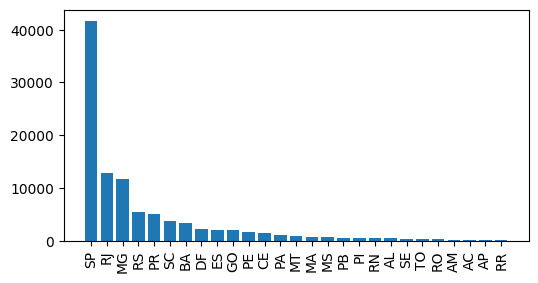

In [11]:
df_sorted = df.sort_values('customer_count',ascending=False)
plt.figure(figsize=(6,3))
plt.bar(df_sorted['state'],df_sorted['customer_count'])
plt.xticks(rotation=90)
plt.show()

# Calculate no. of orders by month in year 2018

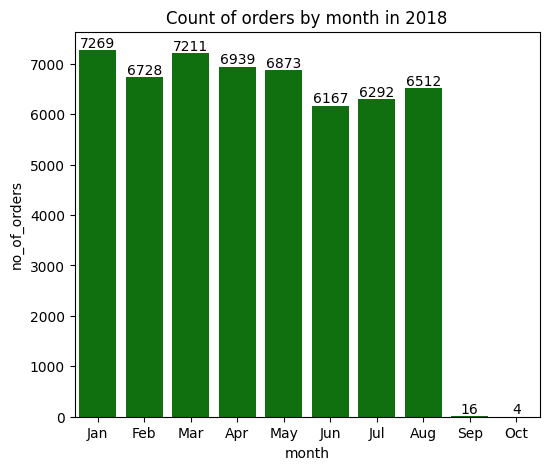

In [13]:
query = '''SELECT date_format(order_purchase_timestamp,'%b') as mnth,COUNT(order_id) as no_of_orders,month(order_purchase_timestamp) as mnth_1
           FROM orders WHERE YEAR(order_purchase_timestamp) = 2018 GROUP BY mnth,mnth_1 order by mnth_1;'''
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns=['month','no_of_orders','a'])
plt.figure(figsize=(6,5))
ax = sns.barplot(x='month',y='no_of_orders',data=df,color='g')
ax.bar_label(ax.containers[0])
plt.title('Count of orders by month in 2018')
plt.show()

# Find the average no. of products per order,grouped by customer city 

In [14]:
query = '''With count_per_order as (SELECT oi.order_id,customer_id,COUNT(oi.order_id) as oc FROM order_item oi JOIN orders o ON o.order_id = oi.order_id
           GROUP BY oi.order_id,customer_id) SELECT c.customer_city,ROUND(AVG(oc),2) avrg_orders   FROM customers c JOIN count_per_order co 
           ON co.customer_id = c.customer_id GROUP BY c.customer_city;'''
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns=['customer_coty','avg_no_of_order'])
df.head()

,customer_coty,avg_no_of_order
0,sao paulo,1.16
1,sao jose dos campos,1.14
2,porto alegre,1.17
3,indaial,1.12
4,treze tilias,1.27


# Calculate the percentage of total revenue contributed by each product category

In [15]:
query = '''SELECT p.product_category,ROUND(SUM(py.payment_value)/(SELECT SUM(payment_value) FROM payments),2) as sales_percentage 
           FROM products p JOIN order_item o ON o.product_id = p.product_id JOIN payments py ON py.order_id = o.order_id 
           GROUP BY p.product_category;'''
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns=['product_category','sales_percentage'])
df.head()                  

,product_category,sales_percentage
0,perfumery,0.03
1,Furniture Decoration,0.09
2,telephony,0.03
3,bed table bath,0.11
4,automotive,0.05


# Identify the correlation between product price and the number of times a product has been purchased.

In [16]:
query = '''SELECT product_category,COUNT(oi.product_id) as cnt,round(avg(price),2) as avg_price FROM products p JOIN order_item oi ON oi.product_id = 
            p.product_id GROUP BY product_category;'''
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns=['product_category','order_count','price'])
df.head()

,product_category,order_count,price
0,HEALTH BEAUTY,9670,130.16
1,sport leisure,8641,114.34
2,Cool Stuff,3796,167.36
3,computer accessories,7827,116.51
4,Watches present,5991,201.14


In [17]:
df[['order_count','price']].corr()

,order_count,price
order_count,1.000000,-0.106315
price,-0.106315,1.000000


# Calculate the total revenue generated by each seller, and rank them by revenue.

In [18]:
query = '''WITH seller_revenue as(SELECT oi.seller_id,SUM(payment_value) as total_revenue FROM order_item oi JOIN payments p ON p.order_id = 
           oi.order_id GROUP BY oi.seller_id) SELECT * ,dense_rank() over(order by total_revenue desc) as rnk FROM seller_revenue;'''
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns=['seller_id','revenue','rank'])
df.head()

,seller_id,revenue,rank
0,7c67e1448b00f6e969d365cea6b010ab,507166.907302,1
1,1025f0e2d44d7041d6cf58b6550e0bfa,308222.039840,2
2,4a3ca9315b744ce9f8e9374361493884,301245.269765,3
3,1f50f920176fa81dab994f9023523100,290253.420128,4
4,53243585a1d6dc2643021fd1853d8905,284903.080498,5


# Calculate the moving average of order values for each customer over their order history.

In [19]:
query = '''WITH customer_purchase_record as (Select customer_id,order_purchase_timestamp,payment_value FROM orders o JOIN payments p ON o.order_id = 
           p.order_id) SELECT *,avg(payment_value) OVER(partition by customer_id ORder by order_purchase_timestamp rows between unbounded 
           preceding and current row) as avg_value FROM customer_purchase_record;'''
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns=['customer_id','timestamp','payment','avg_cumulative_payment'])
df.head()

,customer_id,timestamp,payment,avg_cumulative_payment
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
1,000161a058600d5901f007fab4c27140,2017-07-16 09:40:32,67.41,67.410004
2,0001fd6190edaaf884bcaf3d49edf079,2017-02-28 11:06:43,195.42,195.419998
3,0002414f95344307404f0ace7a26f1d5,2017-08-16 13:09:20,179.35,179.350006
4,000379cdec625522490c315e70c7a9fb,2018-04-02 13:42:17,107.01,107.010002


# Calculate the cumulative sales per month for each year.

In [24]:
query = '''WITH A as (SELECT YEAR(order_purchase_timestamp) as year,Month(order_purchase_timestamp) as mnth, SUM(payment_value) as monthly_revenue 
           FROM orders o JOIN payments p ON p.order_id = o.order_id GROUP BY year,mnth ORDER BY year,mnth) SELECT year,mnth ,SUM(monthly_revenue) 
           OVER(partition by year order by mnth) as cum_revenue FROM A ;'''
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns=['Year','Month','cumulative_revenue'])
df.head()

,Year,Month,cumulative_revenue
0,2016,9,252.239994
1,2016,10,59342.719993
2,2016,12,59362.339994
3,2017,1,138488.040064
4,2017,2,430396.049571


# Calculate the year-over-year growth rate of total sales.

In [4]:
query = '''WIth A as (SELECT YEAR(order_purchase_timestamp) as year, ROUND(SUM(payment_value),2) as yearly_revenue FROM orders o JOIN payments p 
          ON p.order_id = o.order_id GROUP BY year ) SELECT A.*,(yearly_revenue-LAG(yearly_revenue) OVER())*100 DIV yearly_revenue as 
          yoy_growth_prcnt FROM A ORDER BY year;'''
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns=['Year','yearly_revenue','yoy_growth_prcnt'])
df.head()

,Year,yearly_revenue,yoy_growth_prcnt
0,2016,59362.34,NaN
1,2017,7249746.73,99.0
2,2018,8699763.05,16.0


# Identify the top 3 customers who spent the most money in each year.